In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


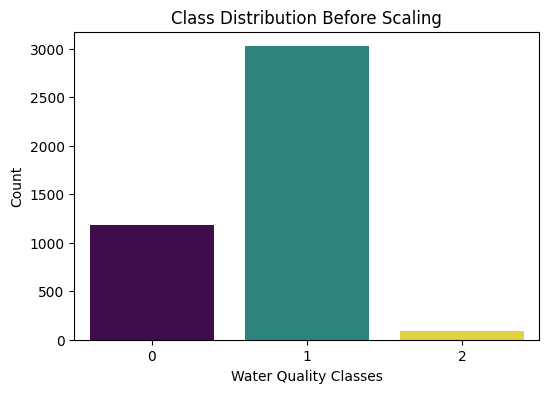

[I 2025-02-24 17:00:18,313] A new study created in memory with name: no-name-5174f0a4-c070-4608-b272-83069d391a5c
[I 2025-02-24 17:00:25,981] Trial 0 finished with value: 0.1712232857942581 and parameters: {'hidden_size_1': 208, 'hidden_size_2': 104, 'hidden_size_3': 34, 'dropout_prob': 0.4750625213228659, 'learning_rate': 0.0022325460987262136}. Best is trial 0 with value: 0.1712232857942581.
[I 2025-02-24 17:00:30,450] Trial 1 finished with value: 0.9206021308898926 and parameters: {'hidden_size_1': 73, 'hidden_size_2': 105, 'hidden_size_3': 36, 'dropout_prob': 0.3552868254717576, 'learning_rate': 6.648818208258824e-05}. Best is trial 0 with value: 0.1712232857942581.
[I 2025-02-24 17:00:34,781] Trial 2 finished with value: 0.967828631401062 and parameters: {'hidden_size_1': 117, 'hidden_size_2': 61, 'hidden_size_3': 60, 'dropout_prob': 0.313229480887936, 'learning_rate': 3.343908389644261e-05}. Best is trial 0 with value: 0.1712232857942581.
[I 2025-02-24 17:00:44,573] Trial 3 finis

Best Hyperparameters Found by Optuna: {'hidden_size_1': 179, 'hidden_size_2': 104, 'hidden_size_3': 36, 'dropout_prob': 0.258592227604231, 'learning_rate': 0.009986947767394607}
Test Accuracy: 98.02%
Precision: 0.9803, Recall: 0.9802, F1-Score: 0.9802
Model saved to /content/drive/My Drive/Aquatic life/water_quality_model.pth
Scaler saved to /content/drive/My Drive/Aquatic life/scaler.pkl


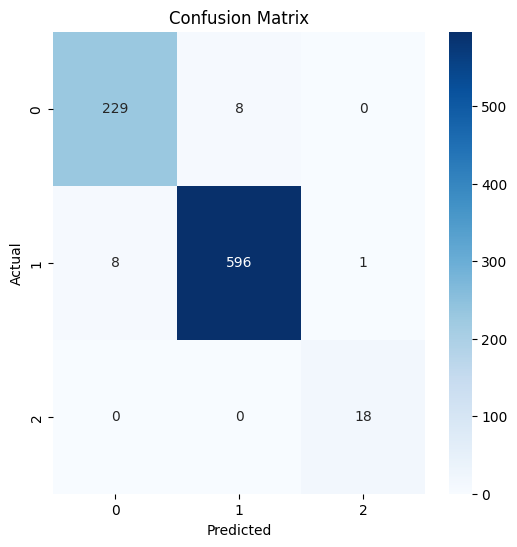

Total Misclassified Samples: 17


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.utils.class_weight import compute_class_weight

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data = pd.read_csv('/content/drive/My Drive/Aquatic life/Finaldata.csv')

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=data['WaterQuality'], palette="viridis", hue=data['WaterQuality'], legend=False)
plt.title("Class Distribution Before Scaling")
plt.xlabel("Water Quality Classes")
plt.ylabel("Count")
plt.show()

# Preprocessing
X = data.drop('WaterQuality', axis=1).values
y = data['WaterQuality'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define Neural Network
class WaterQualityNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, dropout_prob):
        super(WaterQualityNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Define Optuna Optimization
def objective(trial):
    hidden_size_1 = trial.suggest_int('hidden_size_1', 64, 256)
    hidden_size_2 = trial.suggest_int('hidden_size_2', 32, 128)
    hidden_size_3 = trial.suggest_int('hidden_size_3', 16, 64)
    dropout_prob = trial.suggest_float('dropout_prob', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_losses = []

    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = WaterQualityNN(X_scaled.shape[1], hidden_size_1, hidden_size_2, hidden_size_3, dropout_prob)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())

    return np.mean(val_losses)

# Run Optuna Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Train Final Model
best_params = study.best_params
model = WaterQualityNN(X_scaled.shape[1], best_params['hidden_size_1'], best_params['hidden_size_2'], best_params['hidden_size_3'], best_params['dropout_prob'])
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss(weight=class_weights)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate Model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Compute Metrics
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted, average='weighted')
recall = recall_score(y_test, predicted, average='weighted')
f1 = f1_score(y_test, predicted, average='weighted')

# Print Results
print("Best Hyperparameters Found by Optuna:", best_params)
print(f"Test Accuracy: {accuracy * 100:.2f}%\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Save the trained model
model_path = "/content/drive/My Drive/Aquatic life/water_quality_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Save the scaler for consistent preprocessing during inference
scaler_path = "/content/drive/My Drive/Aquatic life/scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Misclassified Samples Analysis
misclassified_indices = np.where(y_test != predicted.numpy())[0]
print(f"Total Misclassified Samples: {len(misclassified_indices)}")


In [1]:
import torch
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define Neural Network Class (Must match the trained model structure)
class WaterQualityNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, dropout_prob):
        super(WaterQualityNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size_1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size_1)
        self.fc2 = torch.nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size_2)
        self.fc3 = torch.nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = torch.nn.BatchNorm1d(hidden_size_3)
        self.fc4 = torch.nn.Linear(hidden_size_3, 3)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Load the trained model
model_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\water_quality_model.pth"
scaler_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\scaler.pkl"

# Load scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# Best hyperparameters from Optuna
best_params = {
    'hidden_size_1': 179,
    'hidden_size_2': 104,
    'hidden_size_3': 36,
    'dropout_prob': 0.2586
}

# Create model instance
model = WaterQualityNN(input_size=14, **best_params)

# Load saved model weights
model.load_state_dict(torch.load(model_path))
model.eval()

# Define class labels
class_labels = {0: "Excellent", 1: "Good", 2: "Poor"}

# Get user input for 14 features
user_input = []
feature_names = [
    "Temp", "Turbidity", "DO", "BOD", "CO2",
    "ph	", "Alkalinity (mg L-1 )", "Hardness (mg L-1 )", "Calcium (mg L-1 )", "Ammonia (mg L-1 )",
    "Nitrite (mg L-1 )", "Phosphorus (mg L-1 )", "H2S (mg L-1 )","Plankton"
]


print("Enter values for the 14 features:")
for feature in feature_names:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Convert user input to numpy array and scale it
user_input_array = np.array(user_input).reshape(1, -1)
user_input_scaled = scaler.transform(user_input_array)

# Convert to PyTorch tensor
user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)

# Make prediction
with torch.no_grad():
    output = model(user_input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Print result
print(f"Predicted Water Quality: {class_labels[predicted_class]}")


Enter values for the 14 features:


Temp:  56
Turbidity:  85
DO:  455
BOD:  41
CO2:  225
ph	:  7.0
Alkalinity (mg L-1 ):  532.2
Hardness (mg L-1 ):  52.55
Calcium (mg L-1 ):  82
Ammonia (mg L-1 ):  563
Nitrite (mg L-1 ):  23
Phosphorus (mg L-1 ):  51
H2S (mg L-1 ):  52
Plankton:  563.3


Predicted Water Quality: Excellent


import torch
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define Neural Network Class (Must match the trained model structure)
class WaterQualityNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, dropout_prob):
        super(WaterQualityNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size_1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size_1)
        self.fc2 = torch.nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size_2)
        self.fc3 = torch.nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = torch.nn.BatchNorm1d(hidden_size_3)
        self.fc4 = torch.nn.Linear(hidden_size_3, 3)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Load the trained model
model_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\water_quality_model.pth"
scaler_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\scaler.pkl"

# Load scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# Best hyperparameters from Optuna
best_params = {
    'hidden_size_1': 179,
    'hidden_size_2': 104,
    'hidden_size_3': 36,
    'dropout_prob': 0.2586
}

# Create model instance
model = WaterQualityNN(input_size=14, **best_params)

# Load saved model weights
model.load_state_dict(torch.load(model_path))
model.eval()

# Define class labels
class_labels = {0: "Excellent", 1: "Good", 2: "Poor"}

# Get user input for 14 features
user_input = []
feature_names = [
    "Temp", "Turbidity", "DO", "BOD", "CO2",
    "ph	", "Alkalinity (mg L-1 )", "Hardness (mg L-1 )", "Calcium (mg L-1 )", "Ammonia (mg L-1 )",
    "Nitrite (mg L-1 )", "Phosphorus (mg L-1 )", "H2S (mg L-1 )","Plankton"
]


print("Enter values for the 14 features:")
for feature in feature_names:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Convert user input to numpy array and scale it
user_input_array = np.array(user_input).reshape(1, -1)
user_input_scaled = scaler.transform(user_input_array)

# Convert to PyTorch tensor
user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)

# Make prediction
with torch.no_grad():
    output = model(user_input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Print result
print(f"Predicted Water Quality: {class_labels[predicted_class]}")


In [2]:
import torch
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define Neural Network Class (Must match the trained model structure)
class WaterQualityNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, dropout_prob):
        super(WaterQualityNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size_1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size_1)
        self.fc2 = torch.nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size_2)
        self.fc3 = torch.nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = torch.nn.BatchNorm1d(hidden_size_3)
        self.fc4 = torch.nn.Linear(hidden_size_3, 3)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Load the trained model
model_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\water_quality_model.pth"
scaler_path = "C:\\Users\\aksha\\Projects\\Research\\Aquatic life\\scaler.pkl"

# Load scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# Best hyperparameters from Optuna
best_params = {
    'hidden_size_1': 179,
    'hidden_size_2': 104,
    'hidden_size_3': 36,
    'dropout_prob': 0.2586
}

# Create model instance
model = WaterQualityNN(input_size=14, **best_params)

# Load saved model weights
model.load_state_dict(torch.load(model_path))
model.eval()

# Define class labels
class_labels = {0: "Excellent", 1: "Good", 2: "Poor"}

# Get user input for 14 features
user_input = []
feature_names = [
    "Temp", "Turbidity", "DO", "BOD", "CO2",
    "ph	", "Alkalinity (mg L-1 )", "Hardness (mg L-1 )", "Calcium (mg L-1 )", "Ammonia (mg L-1 )",
    "Nitrite (mg L-1 )", "Phosphorus (mg L-1 )", "H2S (mg L-1 )","Plankton"
]


print("Enter values for the 14 features:")
for feature in feature_names:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Convert user input to numpy array and scale it
user_input_array = np.array(user_input).reshape(1, -1)
user_input_scaled = scaler.transform(user_input_array)

# Convert to PyTorch tensor
user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)

# Make prediction
with torch.no_grad():
    output = model(user_input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Print result
print(f"Predicted Water Quality: {class_labels[predicted_class]}")


Enter values for the 14 features:


Temp:  0
Turbidity:  2
DO:  3
BOD:  4
CO2:  5
ph	:  8
Alkalinity (mg L-1 ):  9
Hardness (mg L-1 ):  5
Calcium (mg L-1 ):  5
Ammonia (mg L-1 ):  5
Nitrite (mg L-1 ):  5
Phosphorus (mg L-1 ):  2
H2S (mg L-1 ):  5
Plankton:  2


Predicted Water Quality: Excellent
